In [40]:
# Adds link to the scripts folder
import sys
import os
sys.path.append("../scripts/")
import matplotlib.pyplot as plt
import numpy as np

from trajectory import Trajectory, create_trajectory_list, create_all_patient_trajectories
from hivevo.patients import Patient
import filenames
import copy

# Mean frequency over time

In [41]:
def get_mean_in_time(trajectories, nb_bins=15, freq_range=[0.4, 0.6]):
    """
    Computes the mean frequency in time of a set of trajectories from the point they are seen in the freq_range window.
    Returns the middle of the time bins and the computed frequency mean.
    """
    # Create bins and select trajectories going through the freq_range
    time_bins = np.linspace(-1000, 2000, nb_bins)
    trajectories = [traj for traj in trajectories if np.sum(np.logical_and(
        traj.frequencies >= freq_range[0], traj.frequencies < freq_range[1]), dtype=bool)]

    # Offset trajectories to set t=0 at the point they are seen in the freq_range and adds all the frequencies / times
    # to arrays for later computation of mean
    t_traj = np.array([])
    f_traj = np.array([])
    for traj in trajectories:
        idx = np.where(np.logical_and(traj.frequencies >=
                                      freq_range[0], traj.frequencies < freq_range[1]))[0][0]
        traj.t = traj.t - traj.t[idx]
        t_traj = np.concatenate((t_traj, traj.t))
        f_traj = np.concatenate((f_traj, traj.frequencies))

    # Binning of all the data in the time bins
    filtered_fixed = [traj for traj in trajectories if traj.fixation == "fixed"]
    filtered_lost = [traj for traj in trajectories if traj.fixation == "lost"]
    freqs, fixed, lost = [], [], []
    for ii in range(len(time_bins) - 1):
        freqs = freqs + [f_traj[np.logical_and(t_traj >= time_bins[ii], t_traj < time_bins[ii + 1])]]
        fixed = fixed + [len([traj for traj in filtered_fixed if traj.t[-1] < time_bins[ii]])]
        lost = lost + [len([traj for traj in filtered_lost if traj.t[-1] < time_bins[ii]])]

    # Computation of the mean in each bin, active trajectories contribute their current frequency,
    # fixed contribute 1 and lost contribute 0
    mean = []
    for ii in range(len(freqs)):
        mean = mean + [np.sum(freqs[ii]) + fixed[ii]]
        mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])

    return 0.5 * (time_bins[1:] + time_bins[:-1]), mean

def split_traj_fitness(trajectories, first_quantile=0.33, second_quantile=0.66):
    first_quantile_value = np.nanquantile([traj.fitness_cost for traj in trajectories], first_quantile)
    second_quantile_value = np.nanquantile([traj.fitness_cost for traj in trajectories], second_quantile)
    traj_low = [traj for traj in trajectories if (traj.fitness_cost > first_quantile_value) and (traj.fitness_cost < second_quantile_value)]
    traj_high = [traj for traj in trajectories if traj.fitness_cost >= second_quantile_value]
    return traj_low, traj_high

## Creation of the trajectory lists and putting them in dictionnaries

Format of the dictionnaries : trajectories[region][rev/non_rev][low/high]

In [42]:
first_quantile, second_quantile = 0.33, 0.66
regions = ["env", "pol", "gag"]
trajectories = {}

for region in regions:
    # Create the dictionary with the different regions
    tmp_trajectories = create_all_patient_trajectories(region)
    tmp_trajectories = [traj for traj in tmp_trajectories if traj.t[-1] != 0]
    trajectories[region] = tmp_trajectories

    # Split into sub dictionnaries (rev, non_rev and all)
    rev = [traj for traj in trajectories[region] if traj.reversion==True]
    non_rev = [traj for traj in trajectories[region] if traj.reversion==False]
    trajectories[region] = {"rev":rev, "non_rev":non_rev, "all":trajectories[region]}

    # Split into sub sub dictionnaries (low fitness cost, high fitness cost and all)
    for bool_rev in ["rev", "non_rev"]:
        traj_low, traj_high = split_traj_fitness(trajectories[region][bool_rev], first_quantile, second_quantile)
        trajectories[region][bool_rev] = {"low":traj_low, "high":traj_high, "all":trajectories[region][bool_rev]}

# Reversion trajectories

## Fitness cost distributions

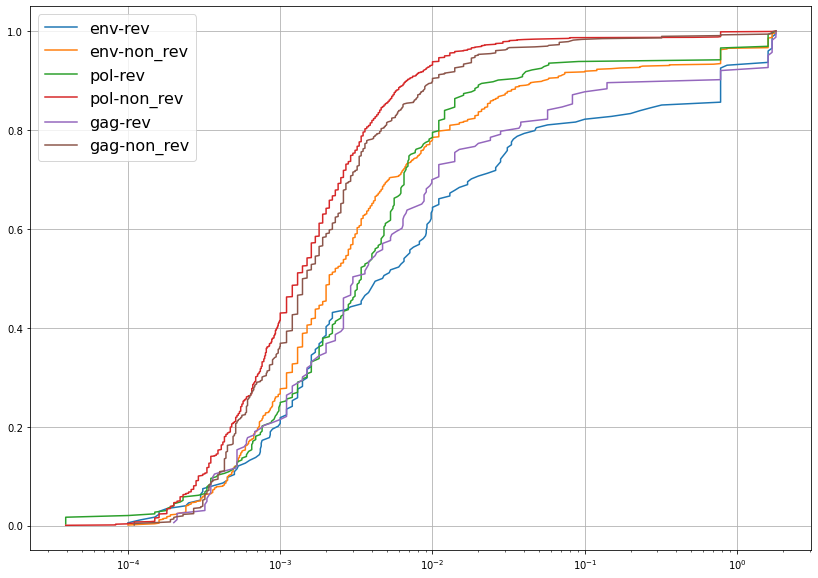

In [43]:
plt.figure(figsize=(14,10))
for region in regions:
    for key in ["rev", "non_rev"]:
        fitness = np.array([traj.fitness_cost for traj in trajectories[region][key]["all"]])
        fitness = np.sort(fitness[~np.isnan(fitness)])
        weights = np.ones_like(fitness)/fitness.shape[0]
        weights = np.cumsum(weights)
        plt.plot(fitness, weights, label=f"{region}-{key}")

plt.xscale("log")
plt.legend(fontsize=16)
plt.grid()
plt.show()

# Mean frequency in time

In [44]:
def plot_means(time_bins, means, freq_ranges, region, reversion, fontsize=16):
    plt.figure(figsize=(14, 10))
    for freq_range in freq_ranges:
        plt.plot(time_bins, means[str(freq_range)][region][reversion]["low"], '.-', label=f"{region}-{reversion}-low")
        plt.plot(time_bins, means[str(freq_range)][region][reversion]["high"], '.-', label=f"{region}-{reversion}-high")
    plt.xlabel("Time [days]", fontsize=fontsize)
    plt.ylabel("Frequency", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.title(f"Region {region}", fontsize=fontsize)
    plt.ylim([0,1])
    plt.grid()
    plt.show()

# Computing the mean frequency in time
# Structure of the dict : mean[freq_range][region][reversion][fitness]
regions = ["env", "pol", "gag"]
reversions = ["rev", "non_rev"]
fitness = ["low", "high"]
nb_bins = 15
freq_ranges = [[0.2, 0.4], [0.4, 0.6], [0.6, 0.8]]
means = {}

for freq_range in freq_ranges:
    means[str(freq_range)] = copy.deepcopy(trajectories)
    for region in regions:
        for reversion in reversions:
            for f in fitness:
                time_bins, tmp_mean = get_mean_in_time(trajectories[region][reversion][f], nb_bins, freq_range)
                means[str(freq_range)][region][reversion][f] = tmp_mean


<ipython-input-41-52d16c7e06ff>:36: RuntimeWarning: invalid value encountered in double_scalars
  mean[-1] /= (len(freqs[ii]) + fixed[ii] + lost[ii])


## Env region
### Reversions

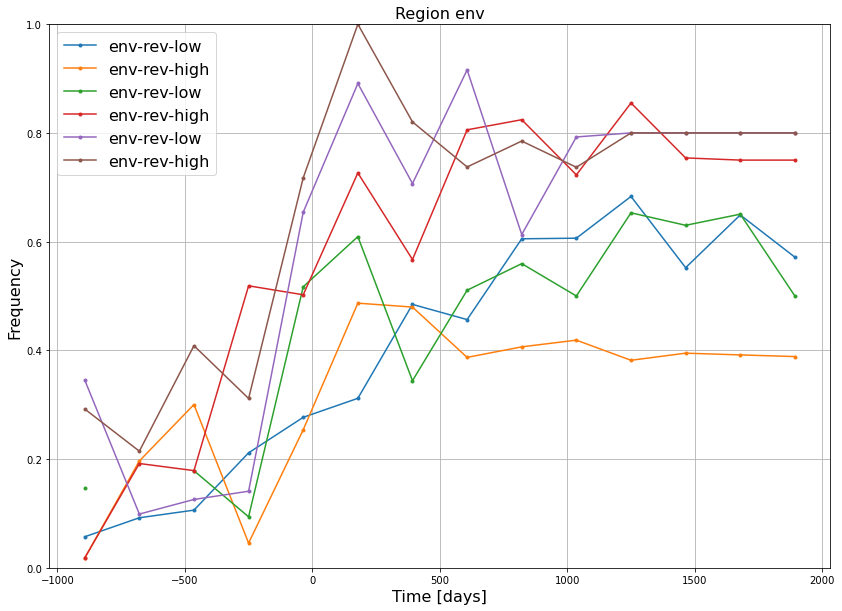

In [45]:
plot_means(time_bins, means, freq_ranges, "env", "rev")

### Non reversions

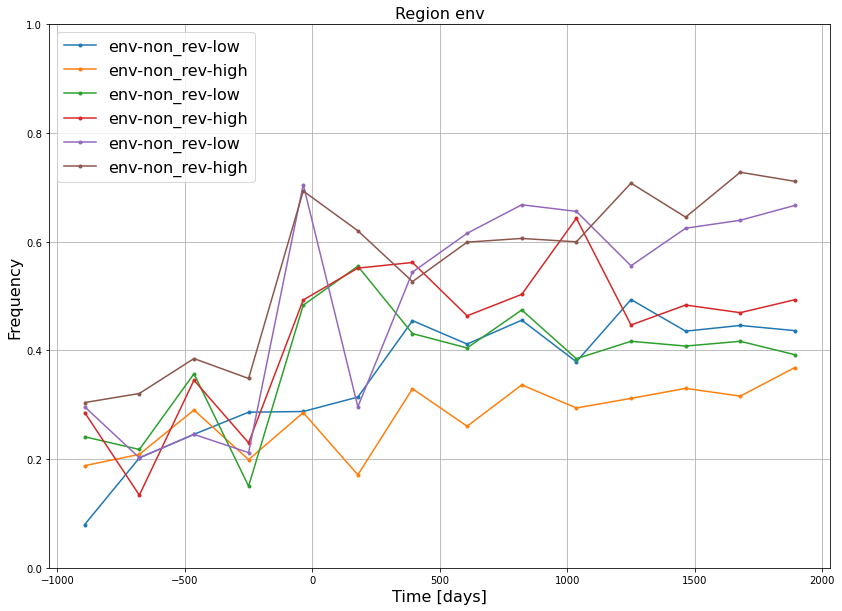

In [46]:
plot_means(time_bins, means, freq_ranges, "env", "non_rev")

## Region pol
### Reversions

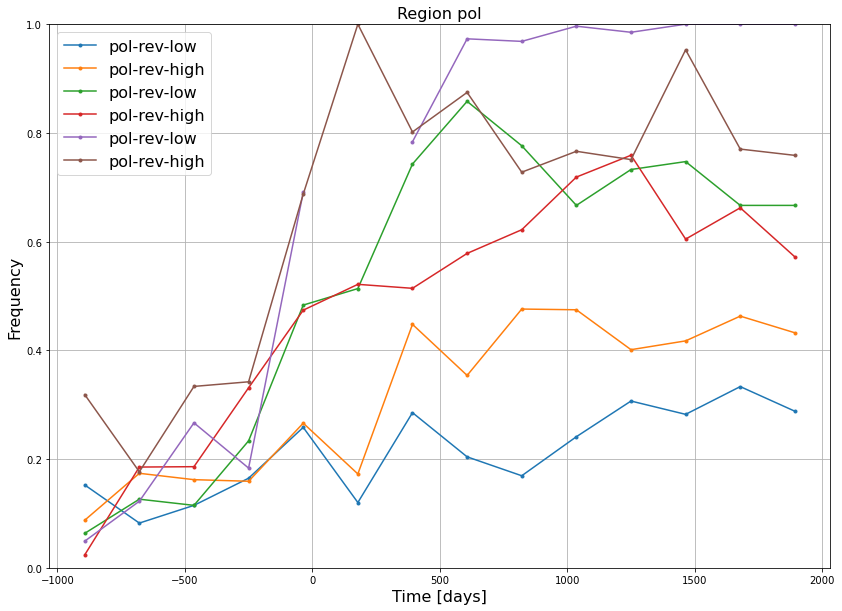

In [47]:
plot_means(time_bins, means, freq_ranges, "pol", "rev")

### Non reversions

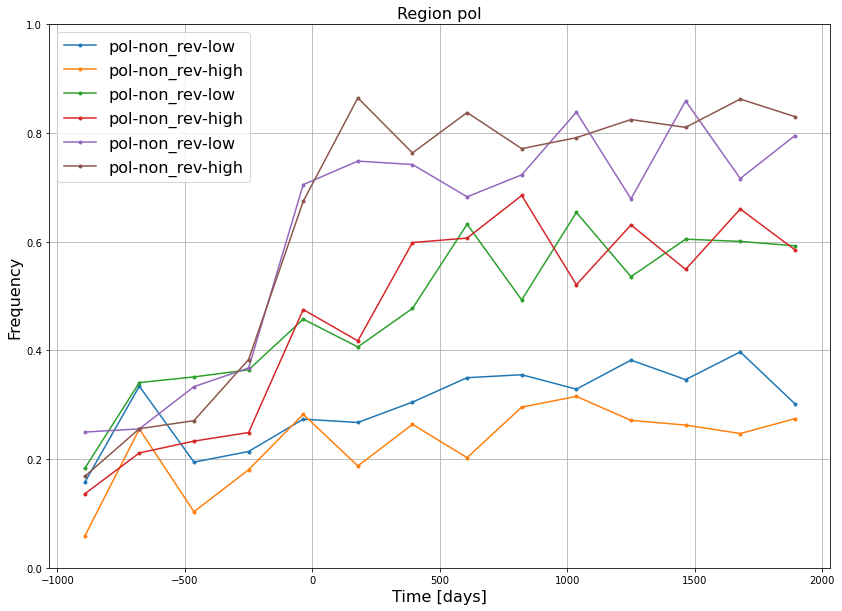

In [48]:
plot_means(time_bins, means, freq_ranges, "pol", "non_rev")

## Region gag
### Reversions

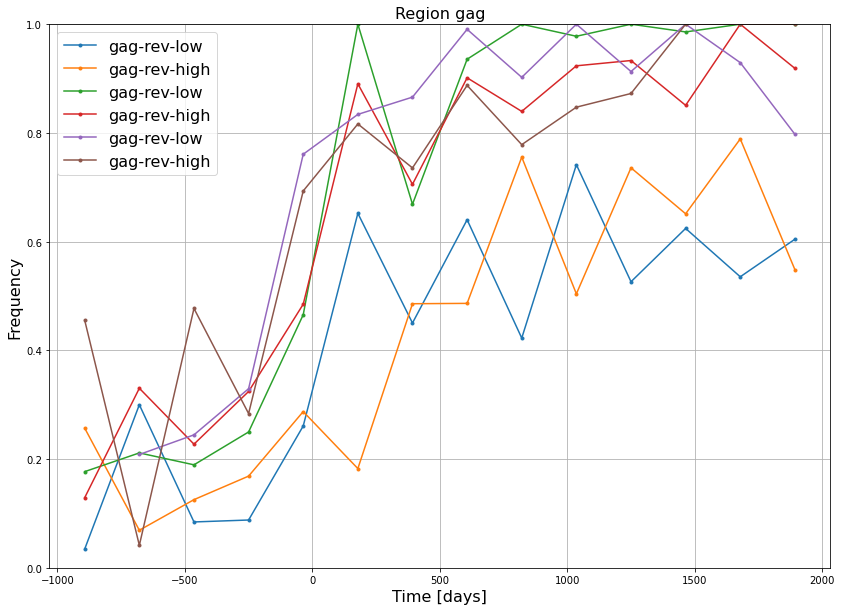

In [49]:
plot_means(time_bins, means, freq_ranges, "gag", "rev")

### Non reversions

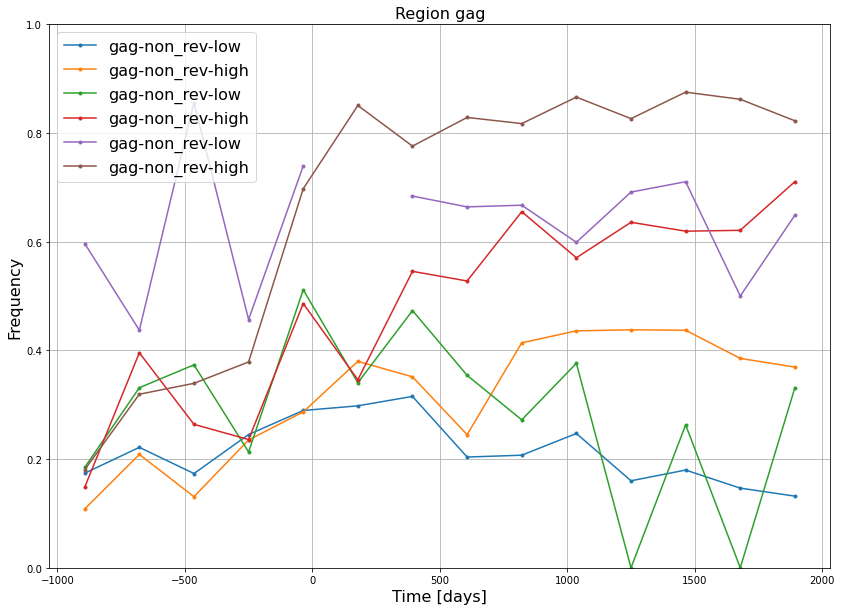

In [50]:
plot_means(time_bins, means, freq_ranges, "gag", "non_rev")

## Comparison between regions
### Reversions

In [51]:
def plot_means2(time_bins, means, regions, reversion, fitness, freq_range=[0.4,0.6], fontsize=16):
    plt.figure(figsize=(14, 10))
    for region in regions:
        plt.plot(time_bins, means[str(freq_range)][region][reversion][fitness], '.-', label=f"{region}-{reversion}-{fitness}")
    plt.xlabel("Time [days]", fontsize=fontsize)
    plt.ylabel("Frequency", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.title(f"{reversion}-{fitness}", fontsize=fontsize)
    plt.ylim([0,1])
    plt.grid()
    plt.show()

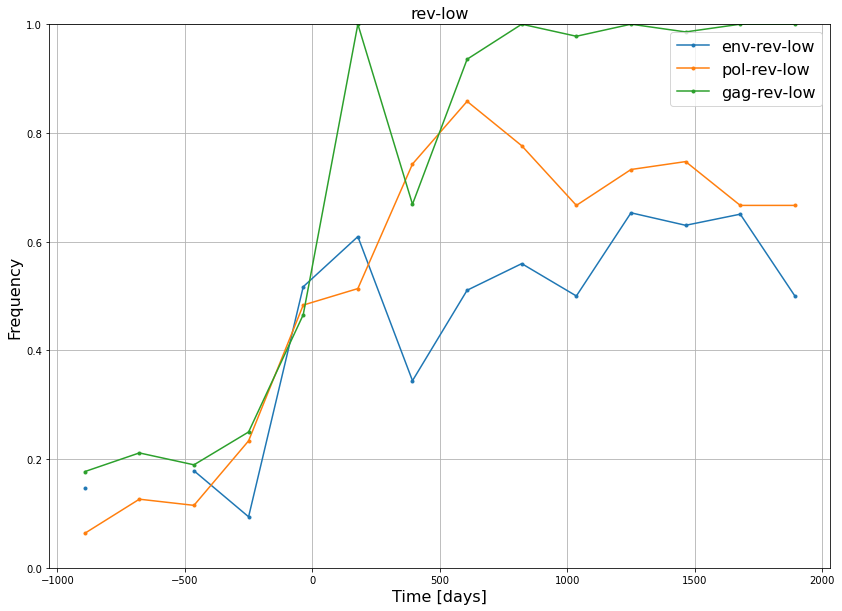

In [52]:
plot_means2(time_bins, means, regions, "rev", "low")

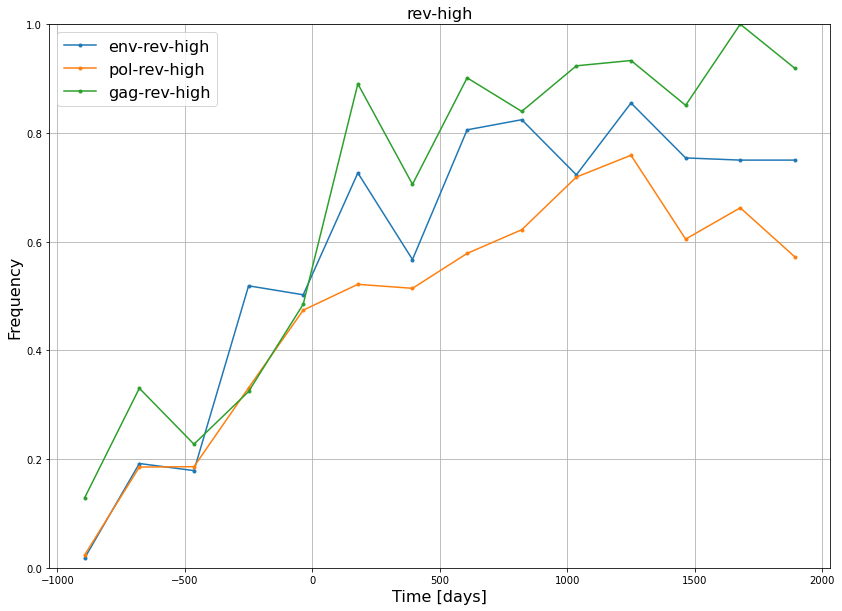

In [53]:
plot_means2(time_bins, means, regions, "rev", "high")

### Non reversions

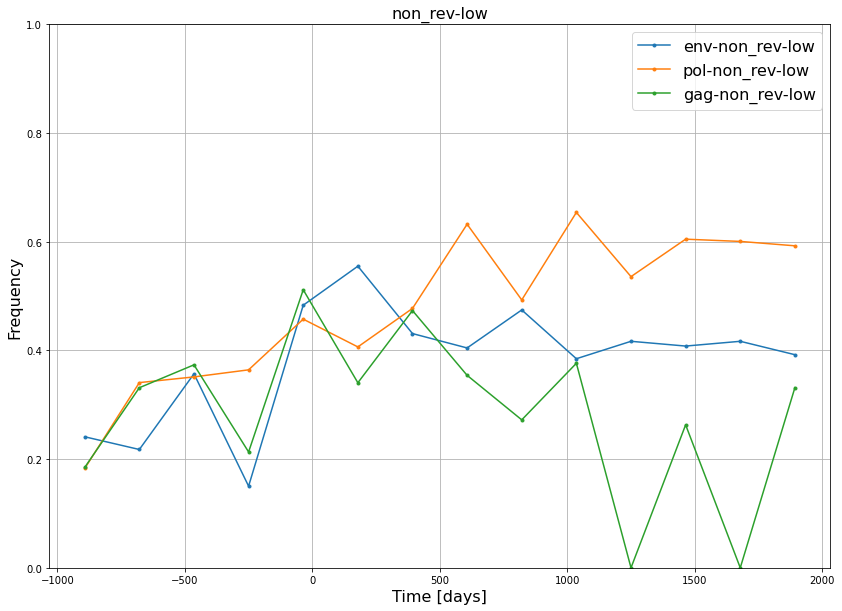

In [54]:
plot_means2(time_bins, means, regions, "non_rev", "low")

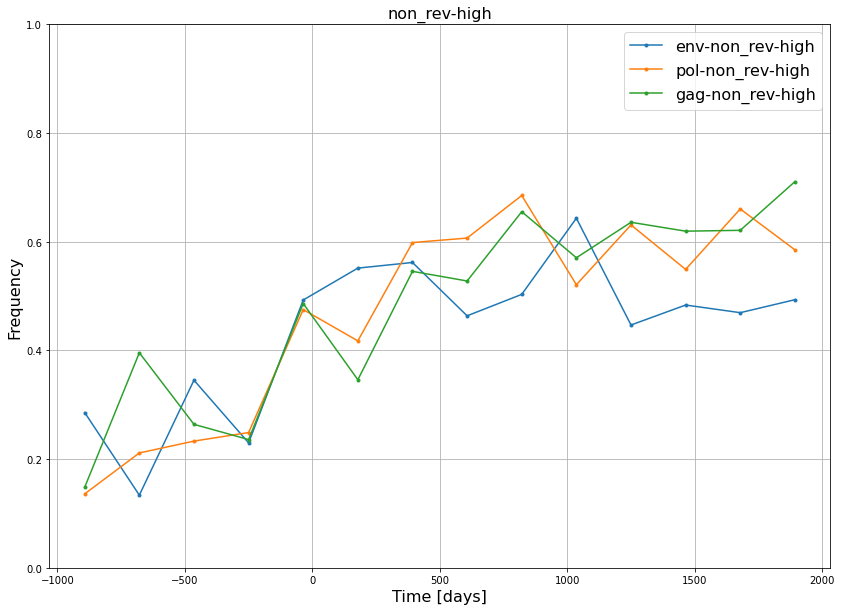

In [55]:
plot_means2(time_bins, means, regions, "non_rev", "high")